In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch
from ipywidgets import VBox, interactive_output, widgets
from IPython.display import display
from viz import (
    get_slider_values,
    plot_enzyme_truth,
    plot_noisy_samples,
    create_enzyme_widgets,
    extract_widget_values,
    Colors,
    plot_gp_fit,
    plot_combined_gp_and_acquisition_from_results,
    plot_selected_rounds,
)
from kinetics import (
    symmetric_noise,
    enzyme_truth,
)

from bo import (
    generate_noisy_observations,
    fit_gp_model,
    perform_bo,
)


SEED = 12345

## Crude Extract
Assume we handle an unknown product broth that has shown to produce a desired product in substantial quantities. The present enzymes and pathways responsible for the production of said product are unknown. In an effort to maximize the product formation, we would like to identify the ideal pH.

## Ground Truth
The kinetics of our different enzyme shall be modeled by Michaelis-Menten. 

$$
v_i = \frac{V_{\text{max},i} [S_i]}{K_{m,i} + [S_i]}
$$

The influence of pH on the maximum reaction rate can be modeled as a Gaussian-like effect.

$$
V_{\text{max},i}(pH) = V_{base,i} \exp\left(-\frac{(pH - pH_{\text{opt},i})^2}{2\sigma_i^2}\right)
$$


In [2]:
bounds_pH = (3.5, 10.5)

pH_values = np.linspace(bounds_pH[0], bounds_pH[1], 500)

config = {
    "Enzyme_1": {
        "Vmax": {"min": 5, "max": 30, "step": 0.1, "value": 14.10}, # mM / min = U /ml
        "Km": {"min": 0.15, "max": 3, "step": 0.1, "value": 0.75}, # mM
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 5.5},
        "sigma": {"min": 0.1, "max": 1.5, "step": 0.1, "value": 0.7},
    },
    "Enzyme_2": {
        "Vmax": {"min": 5, "max": 30, "step": 0.1, "value": 13.1},
        "Km": {"min": 0.15, "max": 3, "step": 0.1, "value": 1.0},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 7.2},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.5},
    },
    "Enzyme_3": {
        "Vmax": {"min": 5, "max": 30, "step": 0.1, "value": 13.5},
        "Km": {"min": 0.15, "max": 3, "step": 0.1, "value": 2.35},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 8.9},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.8},
    },
}

enzyme_widget, enzyme_sliders = create_enzyme_widgets(config=config)


def update_plot(**kwargs):
    enzyme_params = list(extract_widget_values(enzyme_sliders).values())
    plot_enzyme_truth(pH_values, enzyme_params)


slider_kwargs = {
    f"{param}_{i+1}": enzyme_sliders[f"Enzyme_{i+1}"][param]
    for i in range(len(config))
    for param in ["Vmax", "Km", "pH_opt", "sigma"]
}


interactive_plot = interactive_output(update_plot, slider_kwargs)

display(enzyme_widget, interactive_plot)

Output()

In [3]:
# save ground truth parameters selected via widget
enzyme_params = list(extract_widget_values(enzyme_sliders).values())


sigma_0_slider = widgets.FloatSlider(value=0.7, min=0.1, max=5, step=0.1, description="Sigma_0")
sigma_1_slider = widgets.FloatSlider(value=0.8, min=0.1, max=5, step=0.1, description="Sigma_1")
max_noise_slider = widgets.FloatSlider(value=3, min=0.1, max=5, step=0.1, description="Max Noise")


noise_sliders = {
    "sigma_0": sigma_0_slider,
    "sigma_1": sigma_1_slider,
    "max_noise": max_noise_slider,
}


controls = VBox([sigma_0_slider, sigma_1_slider, max_noise_slider])


widget = interactive_output(
    plot_noisy_samples,
    {
        "sigma_0": sigma_0_slider,
        "sigma_1": sigma_1_slider,
        "max_noise": max_noise_slider,
        "bounds": widgets.fixed(bounds_pH),
        "enzyme_params": widgets.fixed(enzyme_params),
    },
)


display(VBox([controls, widget]))

In [4]:
# save noise parameters selected via widget
noise_params = get_slider_values(noise_sliders)

## With custom ground truth and observation noise - Let's start modeling
Here, we select equidistant initial data points and obtain noisy observations.

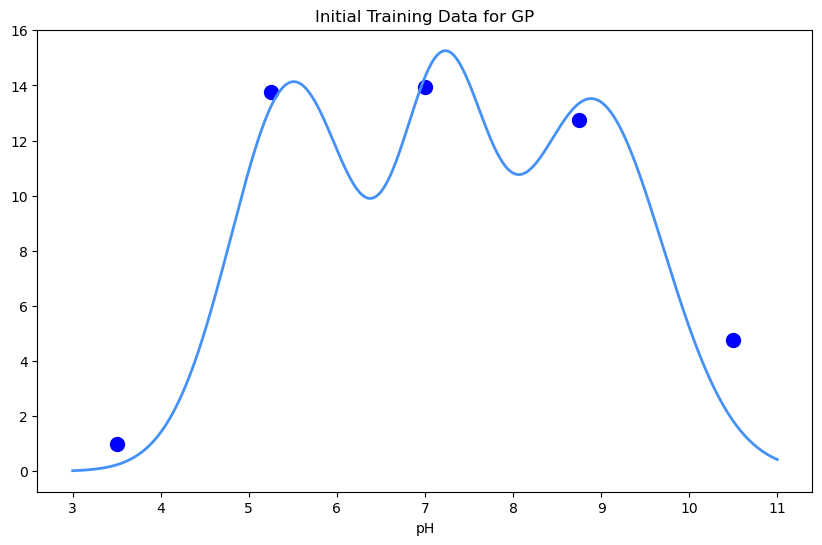

In [5]:
num_points = 5

# Use equidistant points for initial training data, make noisy observations
x_init = np.linspace(bounds_pH[0], bounds_pH[1], num_points)
y_init = generate_noisy_observations(
    x=x_init,
    bounds=bounds_pH,
    truth_fn=enzyme_truth,
    noise_fn=symmetric_noise,
    truth_params=enzyme_params,
    noise_params=noise_params,
    seed=SEED,
)

train_x = torch.tensor(x_init, dtype=torch.double).unsqueeze(-1)
train_y = torch.tensor(y_init, dtype=torch.double).unsqueeze(-1)


# Plot initial training data for reference
plt.figure(figsize=(10, 6))
plt.scatter(
    train_x.numpy(),
    train_y.numpy(),
    color=Colors.dark_blue,
    label="Noisy Observations",
    s=100,
)
pH_range = np.linspace(3, 11, 500)


ground_truth, _ = enzyme_truth(
    pH_range,
    enzyme_params,
)
plt.plot(
    pH_range,
    ground_truth,
    color=Colors.light_blue,
    label="Ground Truth",
    linewidth=2,
)
plt.title("Initial Training Data for GP")
plt.xlabel("pH")
plt.show()

In [6]:
gp_model = fit_gp_model(train_x=train_x, train_y=train_y, bounds=bounds_pH)

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


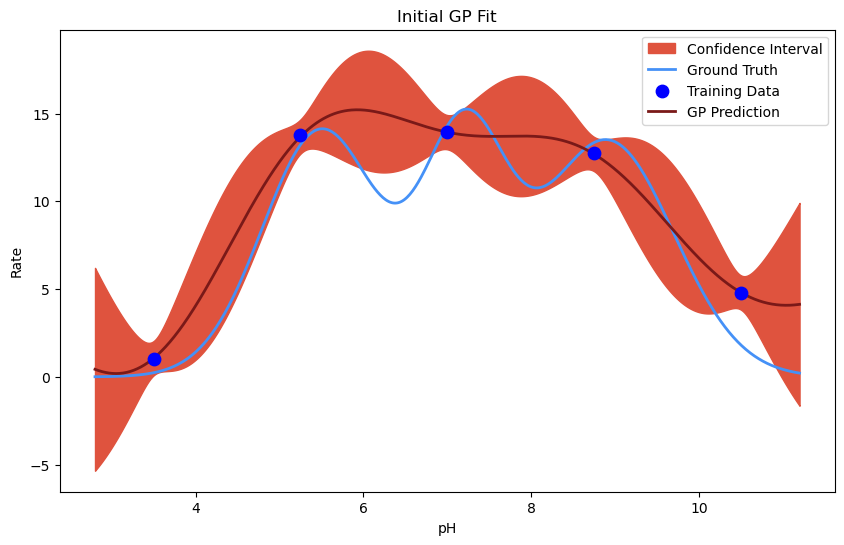

In [7]:
bounds_ax = (2.8, 11.2)

plot_gp_fit(
    gp_model=gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    ground_truth_fn=enzyme_truth,
    ground_truth_params=enzyme_params,
    title="Initial GP Fit",
    xlabel="pH",
    ylabel="Rate",
)

## Collected BO Visualization

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Round 1/8
Round 2/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It i

Round 3/8
Round 4/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It i

Round 5/8
Round 6/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data

Round 7/8
Round 8/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data

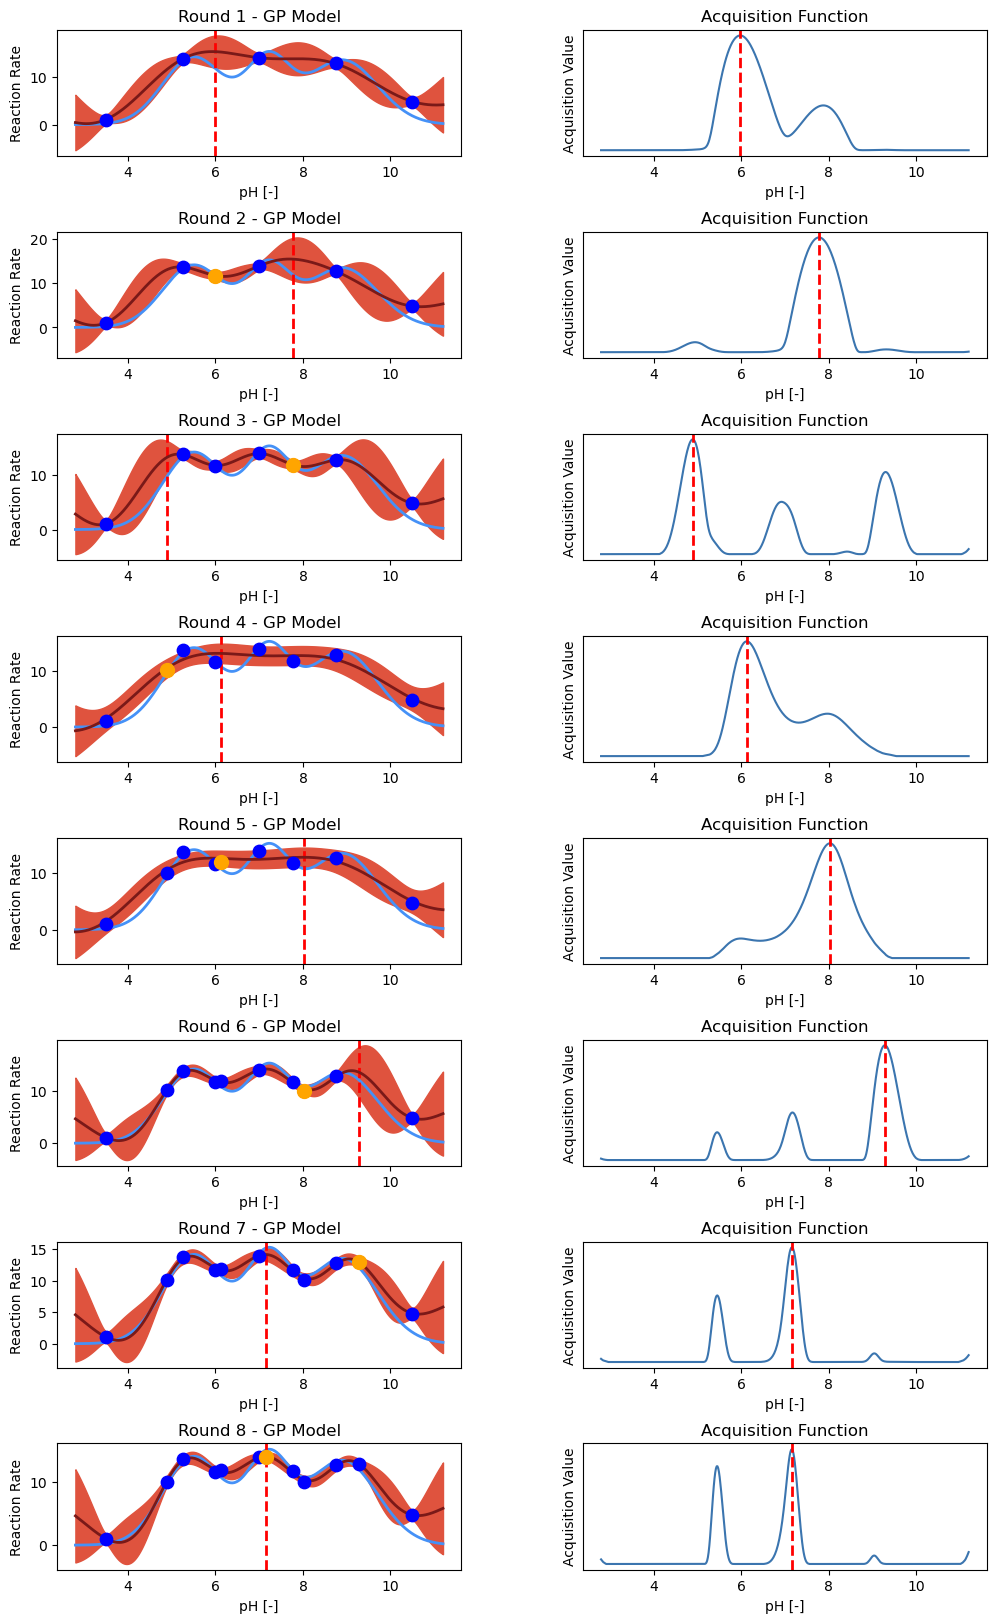

In [8]:
results = perform_bo(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    num_candidates=1,
    num_rounds=8,
    truth_params=enzyme_params,
    noise_params=noise_params,
    method="EI",
    seed=SEED,
)

plot_combined_gp_and_acquisition_from_results(
    results=results,
    bounds=bounds_ax,
    truth_fn=enzyme_truth,
    truth_params=enzyme_params,
)

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


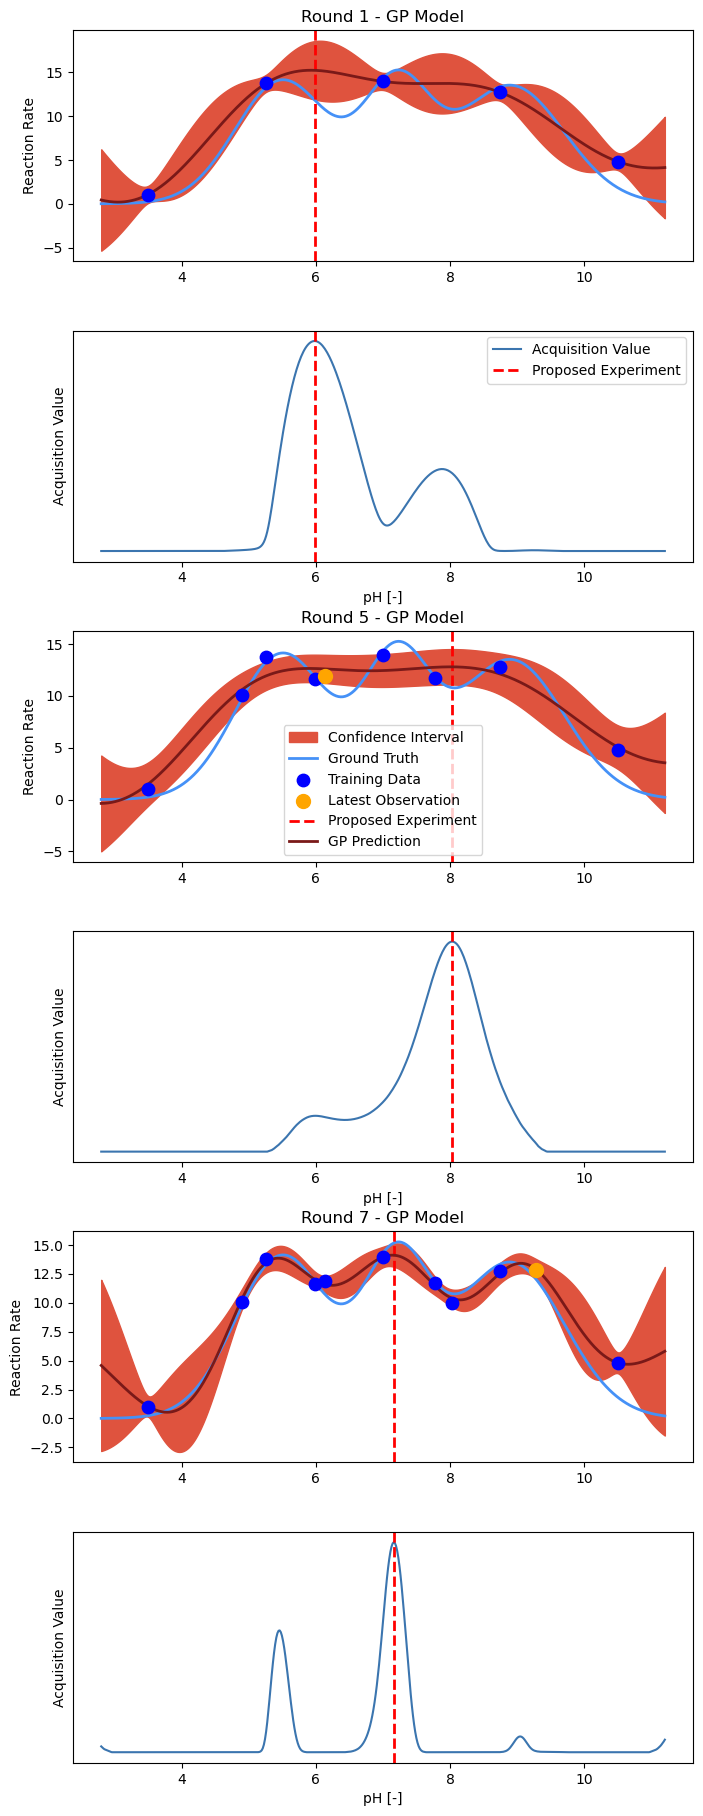

In [9]:
plot_selected_rounds(
    results=results,
    bounds=bounds_ax,
    selected_rounds=[0, 4, 6],
    truth_fn=enzyme_truth,
    truth_params=enzyme_params,
)

